# Customer Analysis Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score, silhouette_score

## Loading Data

Import data into df_orig as original dataset. Create copies of it for different data preprocessing steps.

In [2]:
df_orig = pd.read_csv('Supermarket_customers.csv', sep="\t")
df_orig.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

### Descriptive Statistics

Start exploring the dataset by first creating a copy of the original into df.

In [3]:
df = df_orig.copy()
# Check the shape of the dataset
print(df.shape)

# Check the data types of each column
print(df.dtypes)

# Get a summary of the dataset
print(df.describe())

(2240, 29)
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object
                 ID   Year_Birth         Income      Kidhome     Teenhome  \

Converting Year_Birth into Age makes it easier while still preserving the context.

In [4]:
df['Age'] = 2024 - df['Year_Birth']
df.drop(['Year_Birth'], axis=1, inplace=True)
df

ID   Education Marital_Status   Income  Kidhome  Teenhome  \
0      5524  Graduation         Single  58138.0        0         0   
1      2174  Graduation         Single  46344.0        1         1   
2      4141  Graduation       Together  71613.0        0         0   
3      6182  Graduation       Together  26646.0        1         0   
4      5324         PhD        Married  58293.0        1         0   
...     ...         ...            ...      ...      ...       ...   
2235  10870  Graduation        Married  61223.0        0         1   
2236   4001         PhD       Together  64014.0        2         1   
2237   7270  Graduation       Divorced  56981.0        0         0   
2238   8235      Master       Together  69245.0        0         1   
2239   9405         PhD        Married  52869.0        1         1   

     Dt_Customer  Recency  MntWines  MntFruits  ...  AcceptedCmp3  \
0     04-09-2012       58       635         88  ...             0   
1     08-03-2014       38        11          1  ...             0   
2     21-08-2013       26       426         49  ...             0   
3     10-02-2014       26        11          4  ...             0   
4     19-01-2014       94       173         43  ...             0   
...          ...      ...       ...        ...  ...           ...   
2235  13-06-2013       46       709         43  ...             0   
2236  10-06-2014       56       406          0  ...             0   
2237  25-01-2014       91       908         48  ...             0   
2238  24-01-2014        8       428         30  ...             0   
2239  15-10-2012       40        84          3  ...             0   

      AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0                0             0             0             0         0   
1                0             0             0             0         0   
2                0             0             0             0         0   
3                0             0             0             0         0   
4                0             0             0             0         0   
...            ...           ...           ...           ...       ...   
2235             0             0             0             0         0   
2236             0             0             1             0         0   
2237             1             0             0             0         0   
2238             0             0             0             0         0   
2239             0             0             0             0         0   

      Z_CostContact  Z_Revenue  Response  Age  
0                 3         11         1   67  
1                 3         11         0   70  
2                 3         11         0   59  
3                 3         11         0   40  
4                 3         11         0   43  
...             ...        ...       ...  ...  
2235              3         11         0   57  
2236              3         11         0   78  
2237              3         11         0   43  
2238              3         11         0   68  
2239              3         11         1   70  

[2240 rows x 29 columns]

### Missing Values

In [5]:
# Check for missing values in the 'Income' column
print(df['Income'].isnull().sum())

24


We have 24 missing values in the Income column. There are many ways to handle it, one is to fill it using the mode of Income with the same Education and Marital_Status columns. We could also add Age later and compare it with the existing results.

In [6]:
# Function to impute missing values in 'Income' with the mode based on 'Education' and 'Marital_Status'
def impute_mode(row):
    if pd.isnull(row['Income']):
        return df[(df['Education'] == row['Education']) & 
                  #(df['Age'] == row['Age']) &
                  (df['Marital_Status'] == row['Marital_Status'])]['Income'].mode()[0]
    else:
        return row['Income']

# Apply the function to fill missing values
df['Income'] = df.apply(impute_mode, axis=1)

### Outliers

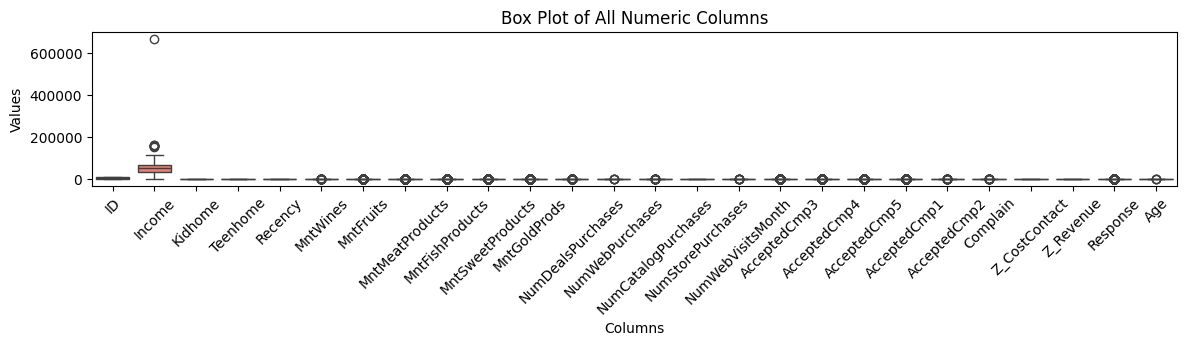

In [7]:
# Set the size of the plot
plt.figure(figsize=(14, 2))

# Create box plots for all numeric columns
sns.boxplot(data=df.select_dtypes(include=[np.number]))

# Add title and labels
plt.title('Box Plot of All Numeric Columns')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

### Handling Outliers

In [8]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier = 200000

# Remove outliers
#df = df[(df['Income'] >= lower_bound) & (df['Income'] <= upper_bound)]
df = df[(df['Income'] >= lower_bound) & (df['Income'] < outlier)]
df.shape

(2239, 29)

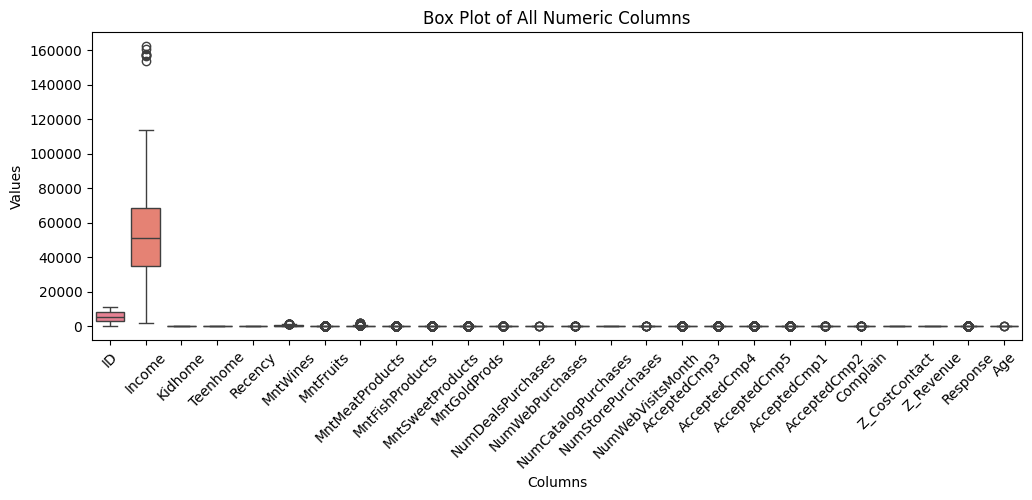

In [9]:
# Set the size of the plot
plt.figure(figsize=(12, 4))

# Create box plots for all numeric columns
sns.boxplot(data=df.select_dtypes(include=[np.number]))

# Add title and labels
plt.title('Box Plot of All Numeric Columns')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [10]:
df.describe()

ID         Income      Kidhome     Teenhome      Recency  \
count   2239.000000    2239.000000  2239.000000  2239.000000  2239.000000   
mean    5590.444841   51621.071907     0.443948     0.506476    49.121036   
std     3246.372471   21744.205378     0.538390     0.544555    28.963662   
min        0.000000    1730.000000     0.000000     0.000000     0.000000   
25%     2827.500000   34733.000000     0.000000     0.000000    24.000000   
50%     5455.000000   51111.000000     0.000000     0.000000    49.000000   
75%     8423.500000   68298.500000     1.000000     1.000000    74.000000   
max    11191.000000  162397.000000     2.000000     2.000000    99.000000   

          MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
count  2239.000000  2239.000000      2239.000000      2239.000000   
mean    304.067441    26.307727       167.016525        37.538633   
std     336.614830    39.781468       225.743829        54.637617   
min       0.000000     0.000000         0.000000         0.000000   
25%      24.000000     1.000000        16.000000         3.000000   
50%     174.000000     8.000000        67.000000        12.000000   
75%     504.500000    33.000000       232.000000        50.000000   
max    1493.000000   199.000000      1725.000000       259.000000   

       MntSweetProducts  ...  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
count       2239.000000  ...   2239.000000   2239.000000   2239.000000   
mean          27.074587  ...      0.072800      0.074587      0.072800   
std           41.286043  ...      0.259867      0.262782      0.259867   
min            0.000000  ...      0.000000      0.000000      0.000000   
25%            1.000000  ...      0.000000      0.000000      0.000000   
50%            8.000000  ...      0.000000      0.000000      0.000000   
75%           33.000000  ...      0.000000      0.000000      0.000000   
max          263.000000  ...      1.000000      1.000000      1.000000   

       AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  Z_Revenue  \
count   2239.000000   2239.000000  2239.000000         2239.0     2239.0   
mean       0.064314      0.013399     0.009379            3.0       11.0   
std        0.245367      0.115001     0.096412            0.0        0.0   
min        0.000000      0.000000     0.000000            3.0       11.0   
25%        0.000000      0.000000     0.000000            3.0       11.0   
50%        0.000000      0.000000     0.000000            3.0       11.0   
75%        0.000000      0.000000     0.000000            3.0       11.0   
max        1.000000      1.000000     1.000000            3.0       11.0   

          Response          Age  
count  2239.000000  2239.000000  
mean      0.149174    55.197856  
std       0.356339    11.985494  
min       0.000000    28.000000  
25%       0.000000    47.000000  
50%       0.000000    54.000000  
75%       0.000000    65.000000  
max       1.000000   131.000000  

[8 rows x 26 columns]

In [ ]:
# Columns Z_CostContact and Z_Revenue have the same value for all entries and doesnt add anything to the data.
df.drop(columns=['Z_CostContact','Z_Revenue'], inplace=True, axis=1)

df = df.set_index('ID')

df.shape

/var/folders/pn/sq35y9ld2d38j62frtw2h194tq6wcq/T/ipykernel_1614/351626334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Z_CostContact','Z_Revenue'], inplace=True, axis=1)


In [12]:
avg_income_by_education = df.groupby('Education')['Income'].mean()
print('Education:', avg_income_by_education.round(2))

avg_income_by_maritalStatus = df.groupby('Marital_Status')['Income'].mean()
print('Marital Status:', avg_income_by_maritalStatus.round(2))

Education: Education
2n Cycle      47118.07
Basic         20306.26
Graduation    51801.17
Master        52477.10
PhD           55912.41
Name: Income, dtype: float64
Marital Status: Marital_Status
Absurd      72365.50
Alone       43789.00
Divorced    52834.23
Married     51429.40
Single      50323.19
Together    51870.98
Widow       56177.26
YOLO        48432.00
Name: Income, dtype: float64


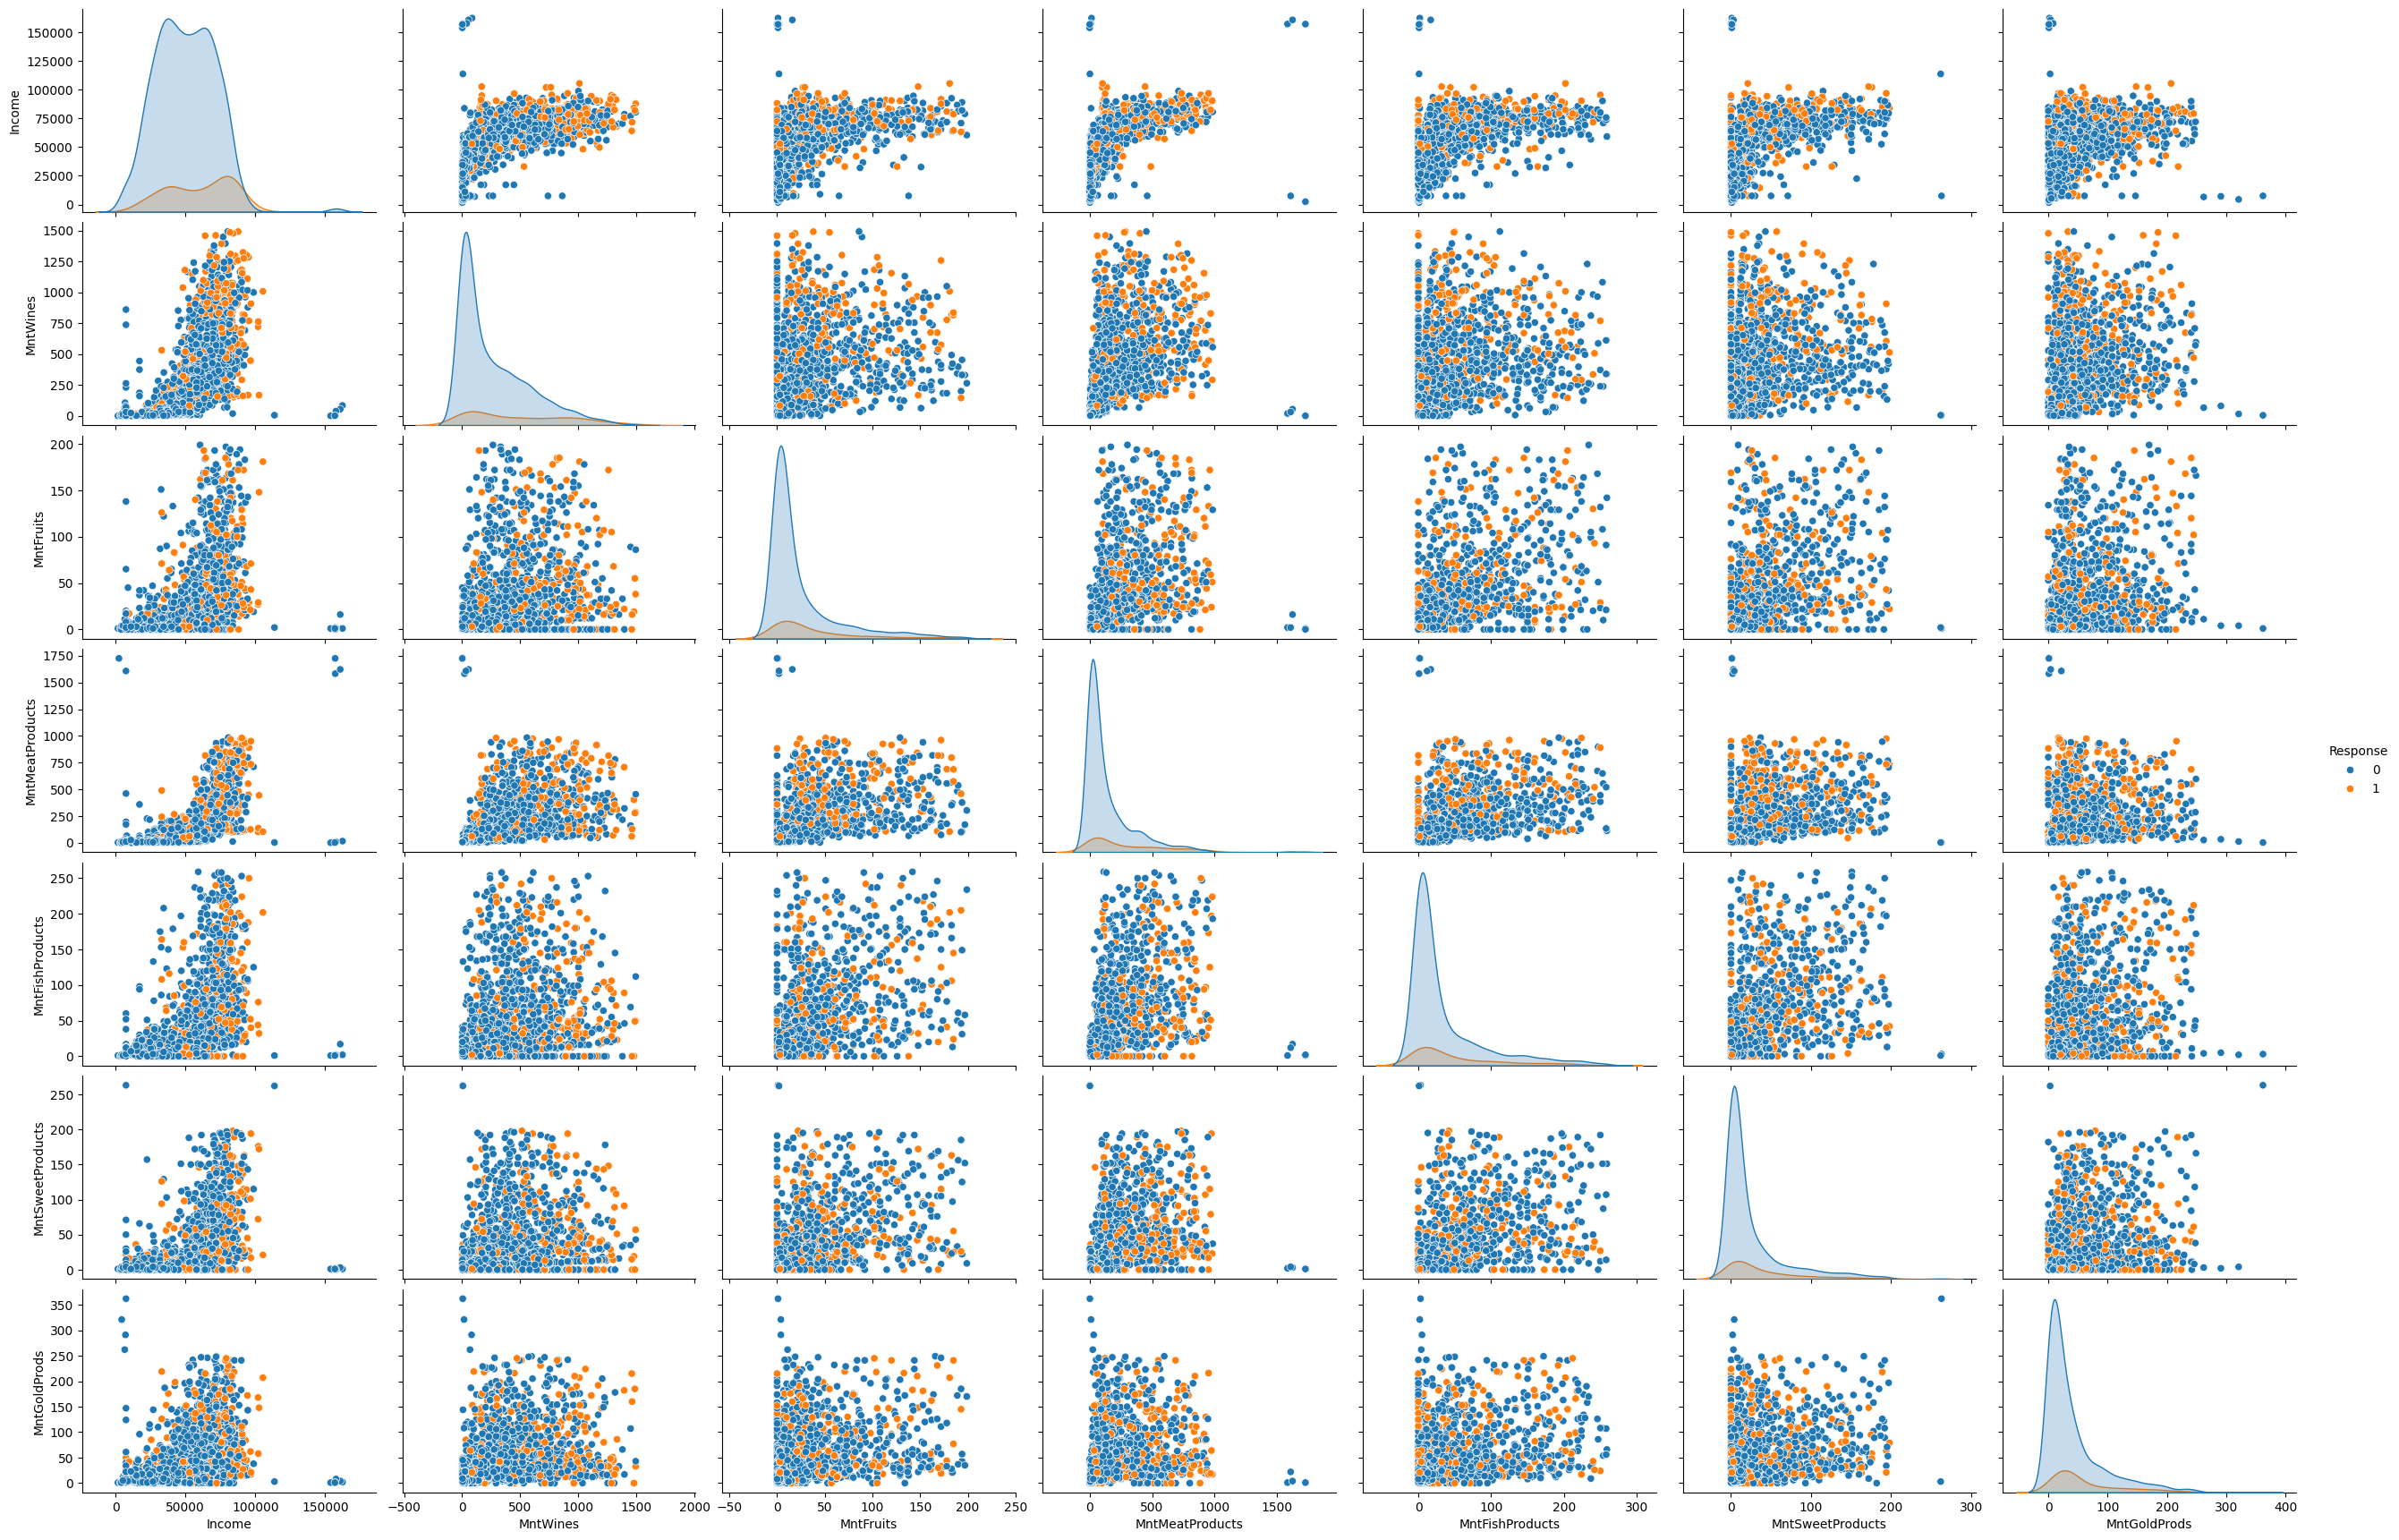

In [14]:
Mnt_features = ['Income', 'MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds', 'Response']
sns.pairplot(df[Mnt_features], hue='Response', height=2.5, aspect=1.5, diag_kind='kde')

### Convert Data Types:

In [13]:
# Convert date strings to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed')

In [16]:
df_encoded = df.copy()
df_encoded['Dt_Customer'] = df_encoded['Dt_Customer'].dt.year.astype('int64')

In [ ]:
# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['Marital_Status'])

In [ ]:
le = LabelEncoder()
df_encoded['Education'] = le.fit_transform(df['Education'])

Education   Income  Kidhome  Teenhome Dt_Customer  Recency  MntWines  \
ID                                                                            
5524           2  58138.0        0         0  2012-04-09       58       635   
2174           2  46344.0        1         1  2014-08-03       38        11   
4141           2  71613.0        0         0  2013-08-21       26       426   
6182           2  26646.0        1         0  2014-10-02       26        11   
5324           4  58293.0        1         0  2014-01-19       94       173   
...          ...      ...      ...       ...         ...      ...       ...   
10870          2  61223.0        0         1  2013-06-13       46       709   
4001           4  64014.0        2         1  2014-10-06       56       406   
7270           2  56981.0        0         0  2014-01-25       91       908   
8235           3  69245.0        0         1  2014-01-24        8       428   
9405           4  52869.0        1         1  2012-10-15       40        84   

       MntFruits  MntMeatProducts  MntFishProducts  ...  Response  Age  \
ID                                                  ...                  
5524          88              546              172  ...         1   67   
2174           1                6                2  ...         0   70   
4141          49              127              111  ...         0   59   
6182           4               20               10  ...         0   40   
5324          43              118               46  ...         0   43   
...          ...              ...              ...  ...       ...  ...   
10870         43              182               42  ...         0   57   
4001           0               30                0  ...         0   78   
7270          48              217               32  ...         0   43   
8235          30              214               80  ...         0   68   
9405           3               61                2  ...         1   70   

       Marital_Status_Absurd  Marital_Status_Alone  Marital_Status_Divorced  \
ID                                                                            
5524                   False                 False                    False   
2174                   False                 False                    False   
4141                   False                 False                    False   
6182                   False                 False                    False   
5324                   False                 False                    False   
...                      ...                   ...                      ...   
10870                  False                 False                    False   
4001                   False                 False                    False   
7270                   False                 False                     True   
8235                   False                 False                    False   
9405                   False                 False                    False   

       Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  \
ID                                                                              
5524                    False                   True                    False   
2174                    False                   True                    False   
4141                    False                  False                     True   
6182                    False                  False                     True   
5324                     True                  False                    False   
...                       ...                    ...                      ...   
10870                    True                  False                    False   
4001                    False                  False                     True   
7270                    False                  False                    False   
8235                    False                  False                     True   
9405            

In [22]:
df_encoded['Dt_Customer'] = df_encoded['Dt_Customer'].dt.year.astype('int64')
df_encoded

Education   Income  Kidhome  Teenhome  Dt_Customer  Recency  MntWines  \
ID                                                                             
5524           2  58138.0        0         0         2012       58       635   
2174           2  46344.0        1         1         2014       38        11   
4141           2  71613.0        0         0         2013       26       426   
6182           2  26646.0        1         0         2014       26        11   
5324           4  58293.0        1         0         2014       94       173   
...          ...      ...      ...       ...          ...      ...       ...   
10870          2  61223.0        0         1         2013       46       709   
4001           4  64014.0        2         1         2014       56       406   
7270           2  56981.0        0         0         2014       91       908   
8235           3  69245.0        0         1         2014        8       428   
9405           4  52869.0        1         1         2012       40        84   

       MntFruits  MntMeatProducts  MntFishProducts  ...  Response  Age  \
ID                                                  ...                  
5524          88              546              172  ...         1   67   
2174           1                6                2  ...         0   70   
4141          49              127              111  ...         0   59   
6182           4               20               10  ...         0   40   
5324          43              118               46  ...         0   43   
...          ...              ...              ...  ...       ...  ...   
10870         43              182               42  ...         0   57   
4001           0               30                0  ...         0   78   
7270          48              217               32  ...         0   43   
8235          30              214               80  ...         0   68   
9405           3               61                2  ...         1   70   

       Marital_Status_Absurd  Marital_Status_Alone  Marital_Status_Divorced  \
ID                                                                            
5524                   False                 False                    False   
2174                   False                 False                    False   
4141                   False                 False                    False   
6182                   False                 False                    False   
5324                   False                 False                    False   
...                      ...                   ...                      ...   
10870                  False                 False                    False   
4001                   False                 False                    False   
7270                   False                 False                     True   
8235                   False                 False                    False   
9405                   False                 False                    False   

       Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  \
ID                                                                              
5524                    False                   True                    False   
2174                    False                   True                    False   
4141                    False                  False                     True   
6182                    False                  False                     True   
5324                     True                  False                    False   
...                       ...                    ...                      ...   
10870                    True                  False                    False   
4001                    False                  False                     True   
7270                    False                  False                    False   
8235                    False                  False                     True   
940

## Exploratory Data Analysis

- Uncover insights about customer behavior and campaign success.

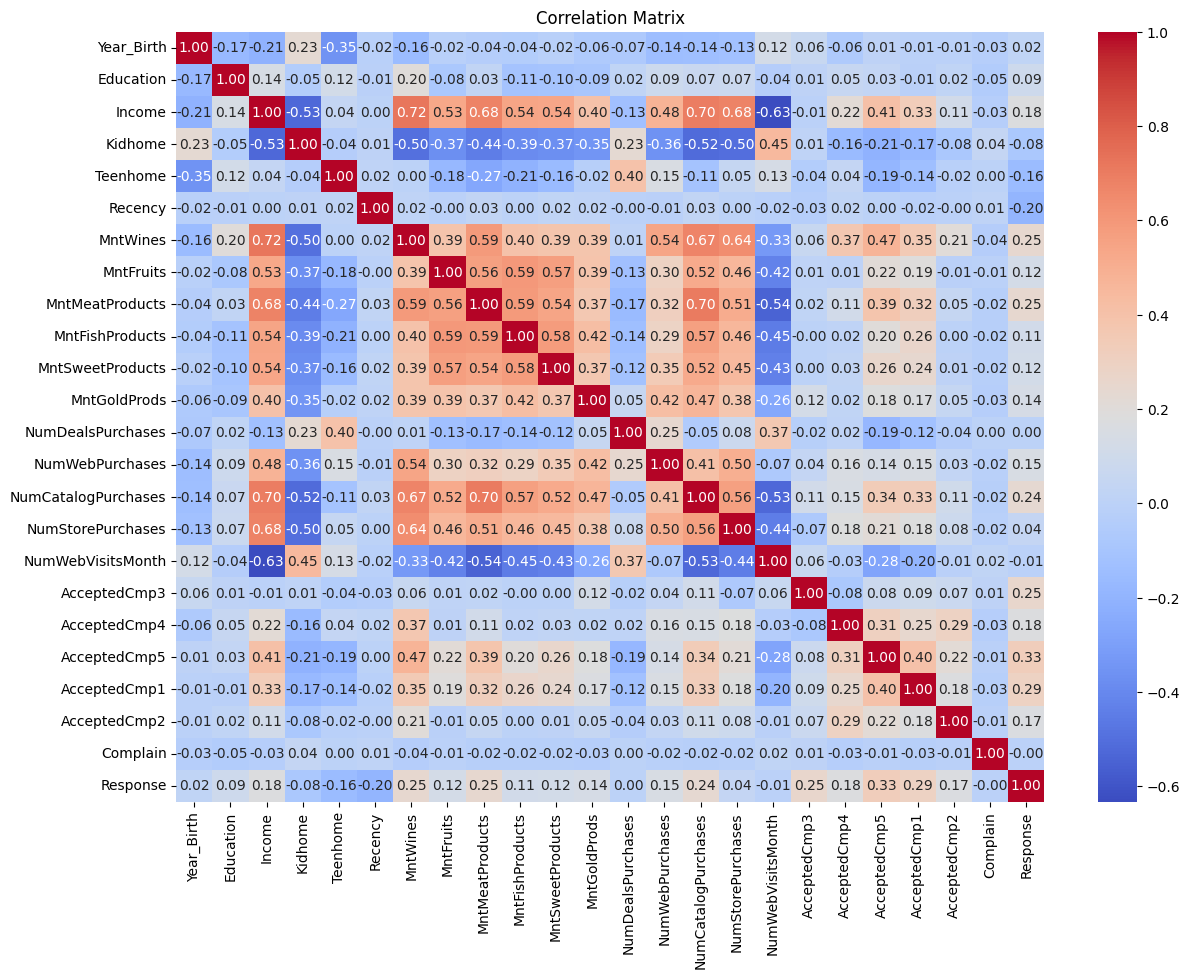

In [20]:
# Example heatmap for correlations
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

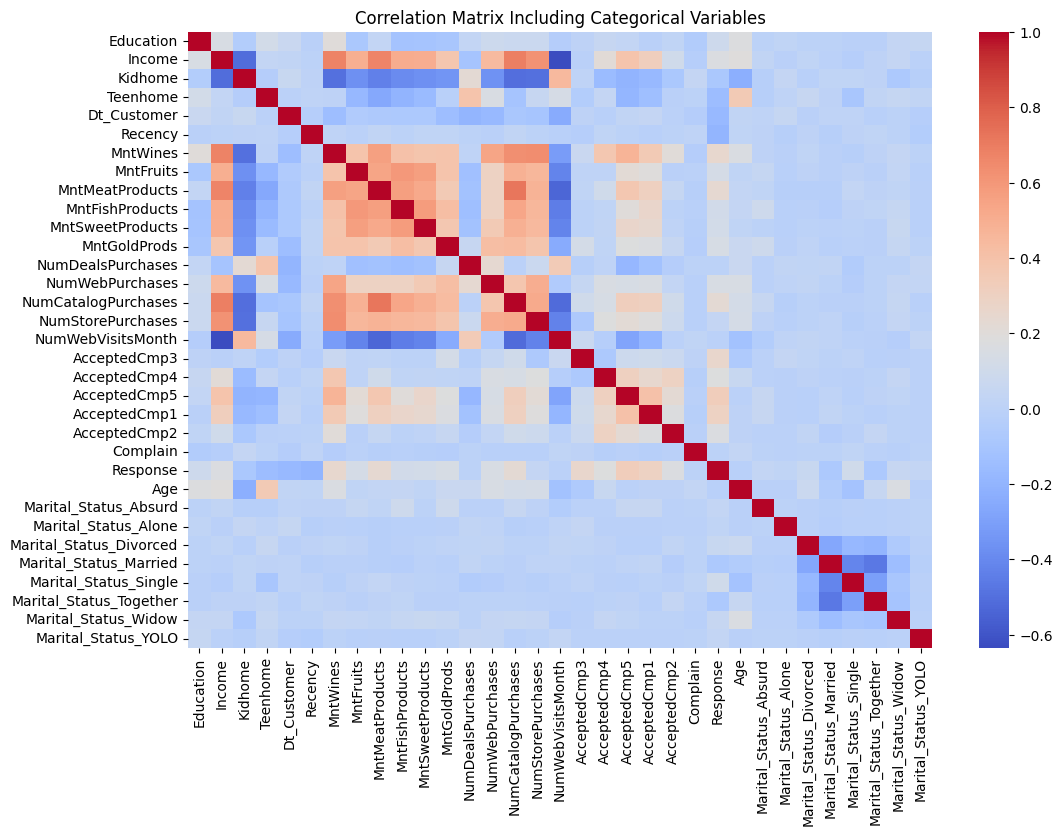

In [22]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Including Categorical Variables')
plt.show()

**Basic Distributions:**

array([[<Axes: title={'center': 'Education'}>,
        <Axes: title={'center': 'Income'}>,
        <Axes: title={'center': 'Kidhome'}>,
        <Axes: title={'center': 'Teenhome'}>,
        <Axes: title={'center': 'Dt_Customer'}>],
       [<Axes: title={'center': 'Recency'}>,
        <Axes: title={'center': 'MntWines'}>,
        <Axes: title={'center': 'MntFruits'}>,
        <Axes: title={'center': 'MntMeatProducts'}>,
        <Axes: title={'center': 'MntFishProducts'}>],
       [<Axes: title={'center': 'MntSweetProducts'}>,
        <Axes: title={'center': 'MntGoldProds'}>,
        <Axes: title={'center': 'NumDealsPurchases'}>,
        <Axes: title={'center': 'NumWebPurchases'}>,
        <Axes: title={'center': 'NumCatalogPurchases'}>],
       [<Axes: title={'center': 'NumStorePurchases'}>,
        <Axes: title={'center': 'NumWebVisitsMonth'}>,
        <Axes: title={'center': 'AcceptedCmp3'}>,
        <Axes: title={'center': 'AcceptedCmp4'}>,
        <Axes: title={'center': 'AcceptedCm

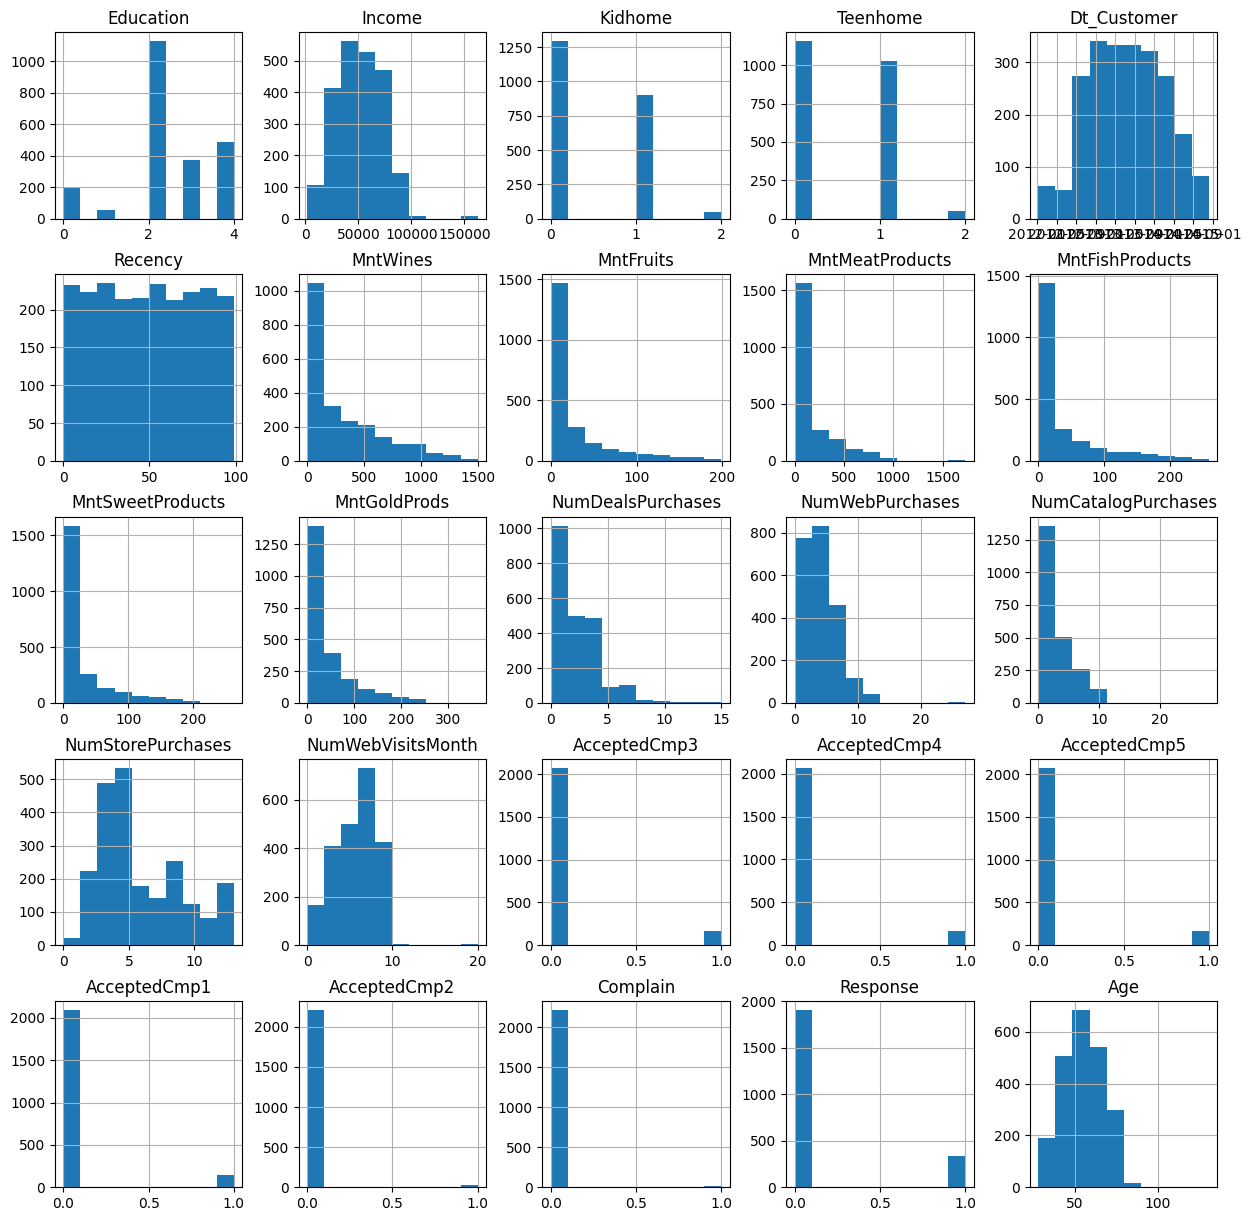

In [19]:
# Plot histograms for numerical variables.
df_encoded.hist(figsize=(15, 15))

<Axes: xlabel='Education', ylabel='count'>

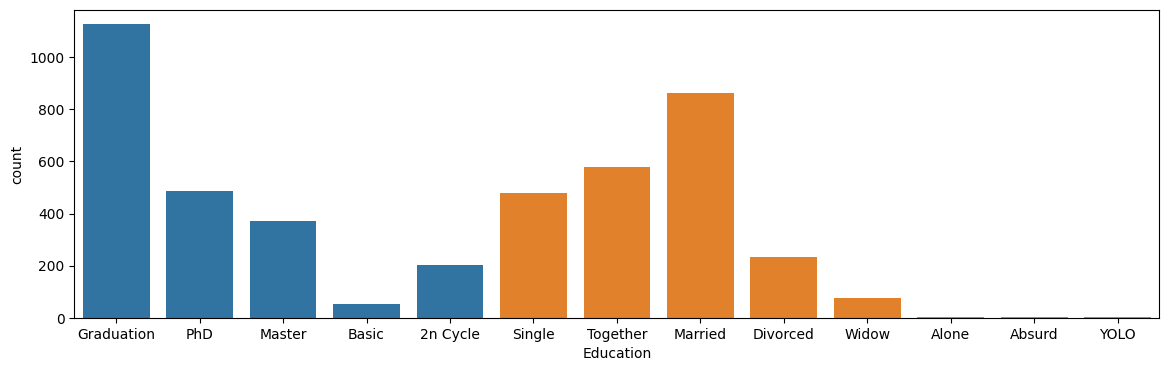

In [23]:
# Visualize categorical distributions
plt.figure(figsize=(14, 4))

sns.countplot(data=df, x='Education')
sns.countplot(data=df, x='Marital_Status')

Text(0.5, 1.0, 'Acceptance Rates for Past Campaigns')

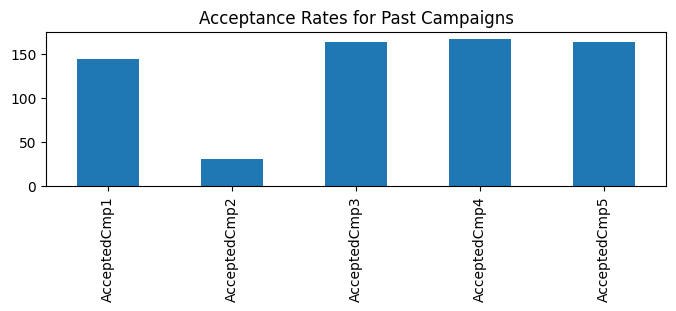

In [21]:
plt.figure(figsize=(8, 2))
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df[campaign_cols].sum().plot(kind='bar')
plt.title("Acceptance Rates for Past Campaigns")

<Axes: title={'center': 'Average Spending by Product Category'}>

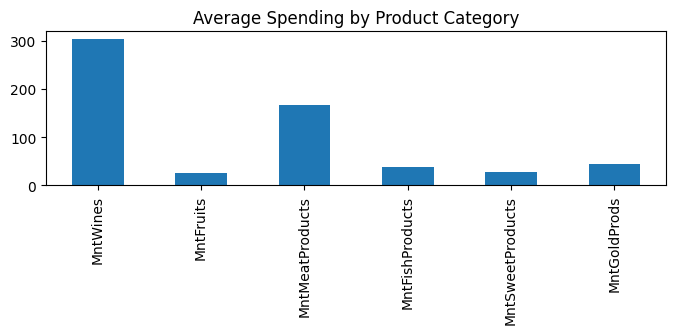

In [22]:
plt.figure(figsize=(8, 2))
product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df[product_cols].mean().plot(kind='bar', title='Average Spending by Product Category')

### Scaling Data

In [23]:
# Scale the data
scaler = RobustScaler()
features = df_encoded
features_scaled = scaler.fit_transform(features)

In [29]:
features_dmg = df_encoded[['Education','Income','Age','Kidhome','Teenhome','Marital_Status_Absurd','Marital_Status_Alone','Marital_Status_Divorced','Marital_Status_Married','Marital_Status_Single','Marital_Status_Together','Marital_Status_Widow','Marital_Status_YOLO']]
df_features = features_dmg.values
features_scaled = scaler.fit_transform(df_features)

## Dimensionality reduction

In [40]:
from sklearn.decomposition import FactorAnalysis, PCA

** Factor Analysis **

In [41]:
fa = FactorAnalysis(n_components=2)
fa.fit(features_scaled)
fa.noise_variance_

array([2.14735117e-01, 1.12815386e-01, 1.80459752e-01, 2.86456236e-01,
       4.65073998e-01, 3.35264800e-01, 1.90116864e-01, 8.63523765e-01,
       4.04383585e-01, 6.92811541e-01, 9.15594767e-01, 8.78247805e-01,
       9.18018676e-01, 3.58145805e-01, 1.80511167e-01, 2.13032067e-01,
       2.24921898e-01, 6.74154181e-02, 6.55147296e-02, 5.42981096e-02,
       5.12881324e-02, 1.30206739e-02, 9.26139387e-03, 1.19040025e-01,
       4.19490696e-01, 8.90523148e-04, 1.33635604e-03, 9.28566605e-02,
       2.36868044e-01, 1.68368776e-01, 1.91513641e-01, 3.30518423e-02,
       8.90327603e-04, 5.44196017e-02])

** PCA **

In [42]:
pca = PCA(n_components=2)
pca_comps = pca.fit_transform(features_scaled)
pca_comps.shape

(2239, 2)

In [ ]:
pca_df = pd.DataFrame(pca_comps, columns=['P1','P2'])
pca_df

** t-SNE **

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features_scaled)

In [ ]:
tsne_df = pd.DataFrame(tsne, columns=['T1','T2'])
tsne_df

## Clustering

### Heirarchical/ Agglomerative

In [32]:
n_clusters = 2  # Example
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = agglomerative.fit_predict(features_scaled)


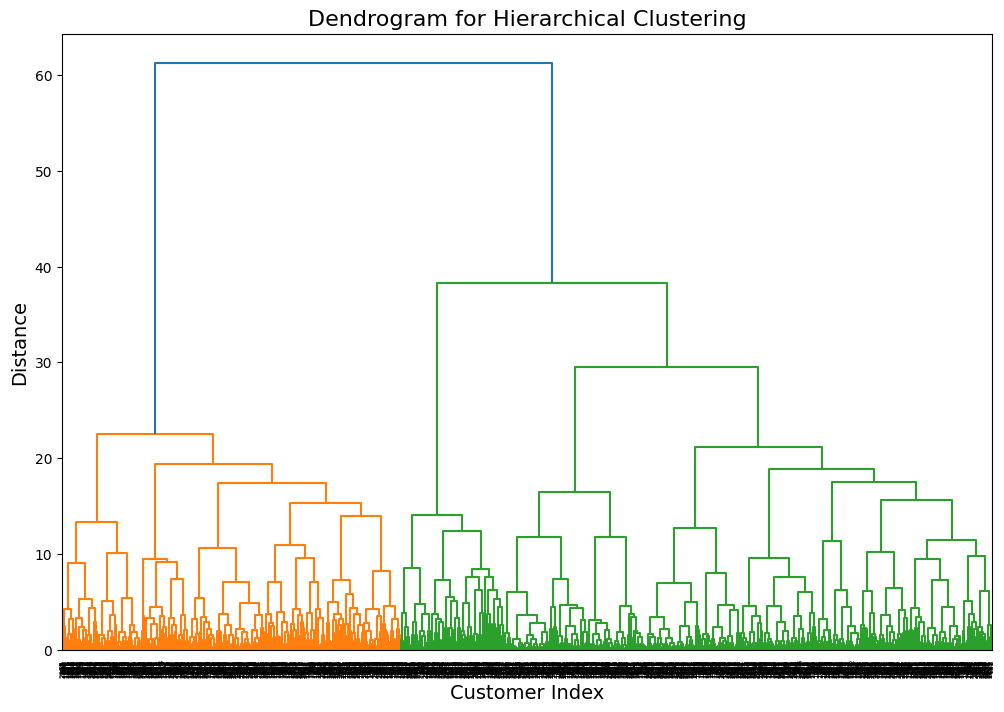

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute linkage matrix
linkage_matrix = linkage(features_scaled, method='ward')

# Plot the dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering", fontsize=16)
plt.xlabel("Customer Index", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.show()


In [34]:
df_encoded['Cluster'] = labels

In [35]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(features_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.21899217600725768


### DBSCAN

In [36]:
# Scale the data
scaler = RobustScaler()
features = df_encoded
features_scaled = scaler.fit_transform(features)

In [37]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(features_scaled)

In [38]:
# Add cluster labels to your original dataframe
df_encoded['Cluster_dbscan'] = clusters

# Count the number of points in each cluster
cluster_counts = df_encoded['Cluster'].value_counts().sort_index()
print(cluster_counts)

Cluster
0    1424
1     815
Name: count, dtype: int64


In [ ]:
df_encoded

In [46]:
pca_dbscan = DBSCAN(eps=0.5, min_samples=5)
pca_clusters = dbscan.fit_predict(features_scaled)

pca_df['clusters'] = pca_clusters

# Count the number of points in each cluster
cluster_counts = pca_df['clusters'].value_counts().sort_index()
print(cluster_counts)

clusters
-1    2239
Name: count, dtype: int64


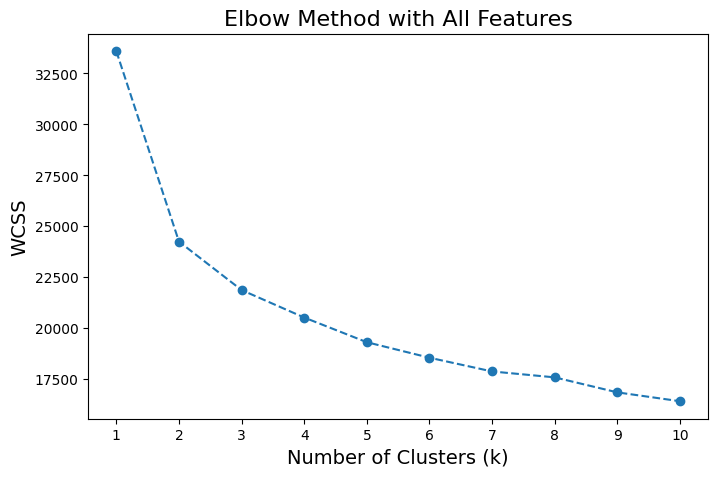

In [48]:
# Using elbow method
wcss = []
for k in range(1, 11):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method with All Features', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.xticks(range(1, 11))
plt.show()


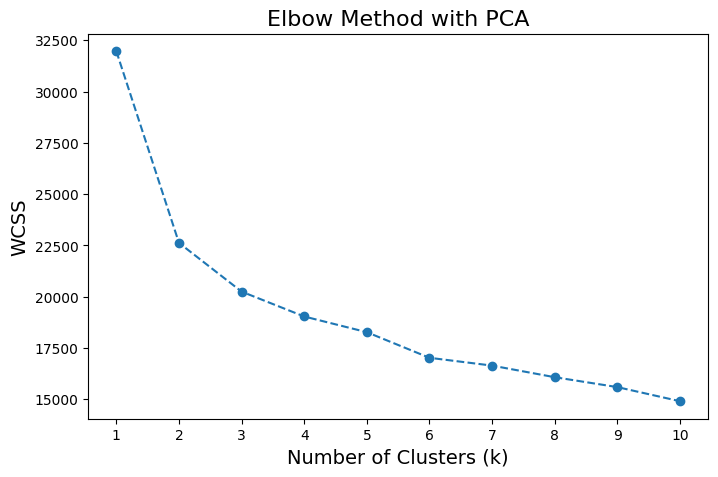

In [49]:
# Apply PCA to reduce dimensions while keeping 95% variance
pca = PCA(n_components=0.95)  # Retain 95% of variance
data_pca = pca.fit_transform(features_scaled)

# Run k-Means on reduced data
wcss_pca = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(data_pca)
    wcss_pca.append(kmeans.inertia_)

# Plot Elbow for PCA-transformed data
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss_pca, marker='o', linestyle='--')
plt.title('Elbow Method with PCA', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.xticks(range(1, 11))
plt.show()


In [47]:
import matplotlib.pyplot as plt

plt.scatter(pca_df[:, 0], pca_df[:, 1], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering Results')
plt.show()

InvalidIndexError: (slice(None, None, None), 0)

### K-Means

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_scaled)

<Axes: xlabel='Cluster', ylabel='MntWines'>

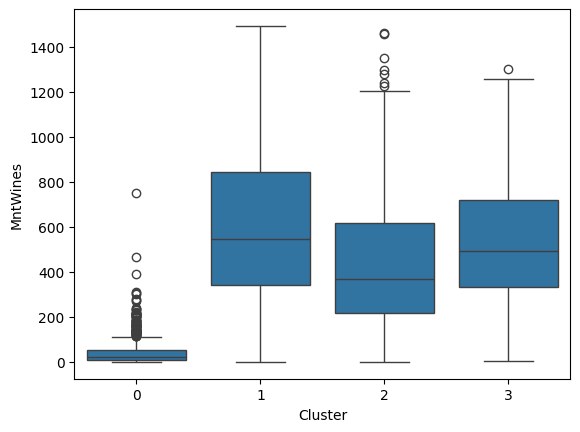

In [33]:
sns.boxplot(x='Cluster', y='MntWines', data=df)

In [34]:
X = df_encoded
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.35022906,  0.29977568, -0.82476876, ..., -0.59058884,
        -0.18871982, -0.02990074],
       [-0.35022906, -0.24274287,  1.03303531, ..., -0.59058884,
        -0.18871982, -0.02990074],
       [-0.35022906,  0.91961944, -0.82476876, ...,  1.69322535,
        -0.18871982, -0.02990074],
       ...,
       [-0.35022906,  0.24655421, -0.82476876, ..., -0.59058884,
        -0.18871982, -0.02990074],
       [ 0.53884448,  0.81069254, -0.82476876, ...,  1.69322535,
        -0.18871982, -0.02990074],
       [ 1.42791803,  0.05740411,  1.03303531, ..., -0.59058884,
        -0.18871982, -0.02990074]])

In [35]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[2 3 2 ... 2 2 2]


In [36]:
df_encoded["Clus_km"] = labels
df_encoded.head(5)

Education   Income  Kidhome  Teenhome  Dt_Customer  Recency  MntWines  \
ID                                                                            
5524          2  58138.0        0         0         2012       58       635   
2174          2  46344.0        1         1         2014       38        11   
4141          2  71613.0        0         0         2013       26       426   
6182          2  26646.0        1         0         2014       26        11   
5324          4  58293.0        1         0         2014       94       173   

      MntFruits  MntMeatProducts  MntFishProducts  ...  Age  \
ID                                                 ...        
5524         88              546              172  ...   67   
2174          1                6                2  ...   70   
4141         49              127              111  ...   59   
6182          4               20               10  ...   40   
5324         43              118               46  ...   43   

      Marital_Status_Absurd  Marital_Status_Alone  Marital_Status_Divorced  \
ID                                                                           
5524                  False                 False                    False   
2174                  False                 False                    False   
4141                  False                 False                    False   
6182                  False                 False                    False   
5324                  False                 False                    False   

      Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  \
ID                                                                             
5524                   False                   True                    False   
2174                   False                   True                    False   
4141                   False                  False                     True   
6182                   False                  False                     True   
5324                    True                  False                    False   

      Marital_Status_Widow  Marital_Status_YOLO  Clus_km  
ID                                                        
5524                 False                False        2  
2174                 False                False        3  
4141                 False                False        2  
6182                 False                False        0  
5324                 False                False        2  

[5 rows x 34 columns]

In [37]:
df_encoded.groupby('Clus_km').mean()

Education        Income   Kidhome  Teenhome  Dt_Customer    Recency  \
Clus_km                                                                        
0         1.936170  22781.191489  0.778723  0.221277  2012.997872  49.053191   
1         2.464373  82721.808354  0.073710  0.240786  2013.100737  49.837838   
2         2.528190  62790.321958  0.201780  0.721068  2012.976261  48.636499   
3         2.533430  41982.510174  0.671512  0.648256  2013.056686  49.218023   

           MntWines  MntFruits  MntMeatProducts  MntFishProducts  ...  \
Clus_km                                                           ...   
0         23.900000   6.025532        26.714894         8.640426  ...   
1        655.673219  64.614251       467.823096        90.911548  ...   
2        474.513353  35.811573       205.683976        50.111276  ...   
3        120.484012   8.191860        47.033430        13.389535  ...   

         Response        Age  Marital_Status_Absurd  Marital_Status_Alone  \
Clus_km                                                                     
0        0.100000  49.631915               0.000000              0.000000   
1        0.314496  56.309582               0.002457              0.000000   
2        0.112760  58.026706               0.001484              0.001484   
3        0.120640  55.571221               0.000000              0.002907   

         Marital_Status_Divorced  Marital_Status_Married  \
Clus_km                                                    
0                       0.089362                0.389362   
1                       0.095823                0.373464   
2                       0.114243                0.408012   
3                       0.107558                0.369186   

         Marital_Status_Single  Marital_Status_Together  Marital_Status_Widow  \
Clus_km                                                                         
0                     0.248936                 0.255319              0.017021   
1                     0.226044                 0.265356              0.036855   
2                     0.178042                 0.255193              0.041543   
3                     0.219477                 0.260174              0.037791   

         Marital_Status_YOLO  
Clus_km                       
0                   0.000000  
1                   0.000000  
2                   0.000000  
3                   0.002907  

[4 rows x 33 columns]